In [0]:
"""
This module merges two files from Scikit-Learn 0.20 to make a few encoders
available for users using an earlier version:
    * sklearn/preprocessing/data.py (OneHotEncoder and CategoricalEncoder)
    * sklearn/compose/_column_transformer.py (ColumnTransformer)
I just copy/pasted the contents, fixed the imports and __all__, and also
copied the definitions of three pipeline functions whose signature changes
in 0.20: _fit_one_transformer, _transform_one and _fit_transform_one.
The original authors are listed below.
----
The :mod:`sklearn.compose._column_transformer` module implements utilities
to work with heterogeneous data and to apply different transformers to
different columns.
"""
# Authors: Andreas Mueller <amueller@ais.uni-bonn.de>
#          Joris Van den Bossche <jorisvandenbossche@gmail.com>
# License: BSD 3 clause

from __future__ import division

import numbers
import warnings

import numpy as np
from scipy import sparse

from sklearn.base import clone, BaseEstimator, TransformerMixin
from sklearn.externals import six
from sklearn.utils import Bunch, check_array
from sklearn.externals.joblib.parallel import delayed, Parallel
from sklearn.utils.metaestimators import _BaseComposition
from sklearn.utils.validation import check_is_fitted, FLOAT_DTYPES
from sklearn.pipeline import _name_estimators
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing.label import LabelEncoder

from itertools import chain


# weight and fit_params are not used but it allows _fit_one_transformer,
# _transform_one and _fit_transform_one to have the same signature to
#  factorize the code in ColumnTransformer
def _fit_one_transformer(transformer, X, y, weight=None, **fit_params):
    return transformer.fit(X, y)


def _transform_one(transformer, X, y, weight, **fit_params):
    res = transformer.transform(X)
    # if we have a weight for this transformer, multiply output
    if weight is None:
        return res
    return res * weight


def _fit_transform_one(transformer, X, y, weight, **fit_params):
    if hasattr(transformer, 'fit_transform'):
        res = transformer.fit_transform(X, y, **fit_params)
    else:
        res = transformer.fit(X, y, **fit_params).transform(X)
    # if we have a weight for this transformer, multiply output
    if weight is None:
        return res, transformer
    return res * weight, transformer


BOUNDS_THRESHOLD = 1e-7


zip = six.moves.zip
map = six.moves.map
range = six.moves.range

__all__ = [
    'OneHotEncoder',
    'OrdinalEncoder',
    'ColumnTransformer',
    'make_column_transformer'
]


def _argmax(arr_or_spmatrix, axis=None):
    return arr_or_spmatrix.argmax(axis=axis)


def _handle_zeros_in_scale(scale, copy=True):
    ''' Makes sure that whenever scale is zero, we handle it correctly.
    This happens in most scalers when we have constant features.'''

    # if we are fitting on 1D arrays, scale might be a scalar
    if np.isscalar(scale):
        if scale == .0:
            scale = 1.
        return scale
    elif isinstance(scale, np.ndarray):
        if copy:
            # New array to avoid side-effects
            scale = scale.copy()
        scale[scale == 0.0] = 1.0
        return scale


def _transform_selected(X, transform, selected="all", copy=True):
    """Apply a transform function to portion of selected features
    Parameters
    ----------
    X : {array-like, sparse matrix}, shape [n_samples, n_features]
        Dense array or sparse matrix.
    transform : callable
        A callable transform(X) -> X_transformed
    copy : boolean, optional
        Copy X even if it could be avoided.
    selected: "all" or array of indices or mask
        Specify which features to apply the transform to.
    Returns
    -------
    X : array or sparse matrix, shape=(n_samples, n_features_new)
    """
    X = check_array(X, accept_sparse='csc', copy=copy, dtype=FLOAT_DTYPES)

    if isinstance(selected, six.string_types) and selected == "all":
        return transform(X)

    if len(selected) == 0:
        return X

    n_features = X.shape[1]
    ind = np.arange(n_features)
    sel = np.zeros(n_features, dtype=bool)
    sel[np.asarray(selected)] = True
    not_sel = np.logical_not(sel)
    n_selected = np.sum(sel)

    if n_selected == 0:
        # No features selected.
        return X
    elif n_selected == n_features:
        # All features selected.
        return transform(X)
    else:
        X_sel = transform(X[:, ind[sel]])
        X_not_sel = X[:, ind[not_sel]]

        if sparse.issparse(X_sel) or sparse.issparse(X_not_sel):
            return sparse.hstack((X_sel, X_not_sel))
        else:
            return np.hstack((X_sel, X_not_sel))


class _BaseEncoder(BaseEstimator, TransformerMixin):
    """
    Base class for encoders that includes the code to categorize and
    transform the input features.
    """

    def _fit(self, X, handle_unknown='error'):

        X_temp = check_array(X, dtype=None)
        if not hasattr(X, 'dtype') and np.issubdtype(X_temp.dtype, np.str_):
            X = check_array(X, dtype=np.object)
        else:
            X = X_temp

        n_samples, n_features = X.shape

        if self.categories != 'auto':
            for cats in self.categories:
                if not np.all(np.sort(cats) == np.array(cats)):
                    raise ValueError("Unsorted categories are not yet "
                                     "supported")
            if len(self.categories) != n_features:
                raise ValueError("Shape mismatch: if n_values is an array,"
                                 " it has to be of shape (n_features,).")

        self._label_encoders_ = [LabelEncoder() for _ in range(n_features)]

        for i in range(n_features):
            le = self._label_encoders_[i]
            Xi = X[:, i]
            if self.categories == 'auto':
                le.fit(Xi)
            else:
                if handle_unknown == 'error':
                    valid_mask = np.in1d(Xi, self.categories[i])
                    if not np.all(valid_mask):
                        diff = np.unique(Xi[~valid_mask])
                        msg = ("Found unknown categories {0} in column {1}"
                               " during fit".format(diff, i))
                        raise ValueError(msg)
                le.classes_ = np.array(self.categories[i])

        self.categories_ = [le.classes_ for le in self._label_encoders_]

    def _transform(self, X, handle_unknown='error'):

        X_temp = check_array(X, dtype=None)
        if not hasattr(X, 'dtype') and np.issubdtype(X_temp.dtype, np.str_):
            X = check_array(X, dtype=np.object)
        else:
            X = X_temp

        _, n_features = X.shape
        X_int = np.zeros_like(X, dtype=np.int)
        X_mask = np.ones_like(X, dtype=np.bool)

        for i in range(n_features):
            Xi = X[:, i]
            valid_mask = np.in1d(Xi, self.categories_[i])

            if not np.all(valid_mask):
                if handle_unknown == 'error':
                    diff = np.unique(X[~valid_mask, i])
                    msg = ("Found unknown categories {0} in column {1}"
                           " during transform".format(diff, i))
                    raise ValueError(msg)
                else:
                    # Set the problematic rows to an acceptable value and
                    # continue `The rows are marked `X_mask` and will be
                    # removed later.
                    X_mask[:, i] = valid_mask
                    Xi = Xi.copy()
                    Xi[~valid_mask] = self.categories_[i][0]
            X_int[:, i] = self._label_encoders_[i].transform(Xi)

        return X_int, X_mask


WARNING_MSG = (
    "The handling of integer data will change in the future. Currently, the "
    "categories are determined based on the range [0, max(values)], while "
    "in the future they will be determined based on the unique values.\n"
    "If you want the future behaviour, you can specify \"categories='auto'\"."
)


class OneHotEncoder(_BaseEncoder):
    """Encode categorical integer features as a one-hot numeric array.
    The input to this transformer should be an array-like of integers or
    strings, denoting the values taken on by categorical (discrete) features.
    The features are encoded using a one-hot (aka 'one-of-K' or 'dummy')
    encoding scheme. This creates a binary column for each category and
    returns a sparse matrix or dense array.
    By default, the encoder derives the categories based on the unique values
    in each feature. Alternatively, you can also specify the `categories`
    manually.
    The OneHotEncoder previously assumed that the input features take on
    values in the range [0, max(values)). This behaviour is deprecated.
    This encoding is needed for feeding categorical data to many scikit-learn
    estimators, notably linear models and SVMs with the standard kernels.
    Note: a one-hot encoding of y labels should use a LabelBinarizer
    instead.
    Read more in the :ref:`User Guide <preprocessing_categorical_features>`.
    Parameters
    ----------
    categories : 'auto' or a list of lists/arrays of values.
        Categories (unique values) per feature:
        - 'auto' : Determine categories automatically from the training data.
        - list : ``categories[i]`` holds the categories expected in the ith
          column. The passed categories must be sorted and should not mix
          strings and numeric values.
        The used categories can be found in the ``categories_`` attribute.
    sparse : boolean, default=True
        Will return sparse matrix if set True else will return an array.
    dtype : number type, default=np.float
        Desired dtype of output.
    handle_unknown : 'error' (default) or 'ignore'
        Whether to raise an error or ignore if a unknown categorical feature is
        present during transform (default is to raise). When this parameter
        is set to 'ignore' and an unknown category is encountered during
        transform, the resulting one-hot encoded columns for this feature
        will be all zeros. In the inverse transform, an unknown category
        will be denoted as None.
    n_values : 'auto', int or array of ints
        Number of values per feature.
        - 'auto' : determine value range from training data.
        - int : number of categorical values per feature.
                Each feature value should be in ``range(n_values)``
        - array : ``n_values[i]`` is the number of categorical values in
                  ``X[:, i]``. Each feature value should be
                  in ``range(n_values[i])``
        .. deprecated:: 0.20
            The `n_values` keyword is deprecated and will be removed in 0.22.
            Use `categories` instead.
    categorical_features : "all" or array of indices or mask
        Specify what features are treated as categorical.
        - 'all' (default): All features are treated as categorical.
        - array of indices: Array of categorical feature indices.
        - mask: Array of length n_features and with dtype=bool.
        Non-categorical features are always stacked to the right of the matrix.
        .. deprecated:: 0.20
            The `categorical_features` keyword is deprecated and will be
            removed in 0.22.
    Attributes
    ----------
    categories_ : list of arrays
        The categories of each feature determined during fitting
        (in order corresponding with output of ``transform``).
    active_features_ : array
        Indices for active features, meaning values that actually occur
        in the training set. Only available when n_values is ``'auto'``.
        .. deprecated:: 0.20
    feature_indices_ : array of shape (n_features,)
        Indices to feature ranges.
        Feature ``i`` in the original data is mapped to features
        from ``feature_indices_[i]`` to ``feature_indices_[i+1]``
        (and then potentially masked by `active_features_` afterwards)
        .. deprecated:: 0.20
    n_values_ : array of shape (n_features,)
        Maximum number of values per feature.
        .. deprecated:: 0.20
    Examples
    --------
    Given a dataset with two features, we let the encoder find the unique
    values per feature and transform the data to a binary one-hot encoding.
    >>> from sklearn.preprocessing import OneHotEncoder
    >>> enc = OneHotEncoder(handle_unknown='ignore')
    >>> X = [['Male', 1], ['Female', 3], ['Female', 2]]
    >>> enc.fit(X)
    ... # doctest: +ELLIPSIS
    OneHotEncoder(categories='auto', dtype=<... 'numpy.float64'>,
           handle_unknown='ignore', sparse=True)
    >>> enc.categories_
    [array(['Female', 'Male'], dtype=object), array([1, 2, 3], dtype=object)]
    >>> enc.transform([['Female', 1], ['Male', 4]]).toarray()
    array([[ 1.,  0.,  1.,  0.,  0.],
           [ 0.,  1.,  0.,  0.,  0.]])
    >>> enc.inverse_transform([[0, 1, 1, 0, 0], [0, 0, 0, 1, 0]])
    array([['Male', 1],
           [None, 2]], dtype=object)
    See also
    --------
    sklearn.preprocessing.OrdinalEncoder : performs an ordinal (integer)
      encoding of the categorical features.
    sklearn.feature_extraction.DictVectorizer : performs a one-hot encoding of
      dictionary items (also handles string-valued features).
    sklearn.feature_extraction.FeatureHasher : performs an approximate one-hot
      encoding of dictionary items or strings.
    sklearn.preprocessing.LabelBinarizer : binarizes labels in a one-vs-all
      fashion.
    sklearn.preprocessing.MultiLabelBinarizer : transforms between iterable of
      iterables and a multilabel format, e.g. a (samples x classes) binary
      matrix indicating the presence of a class label.
    """

    def __init__(self, n_values=None, categorical_features=None,
                 categories=None, sparse=True, dtype=np.float64,
                 handle_unknown='error'):
        self._categories = categories
        if categories is None:
            self.categories = 'auto'
        else:
            self.categories = categories
        self.sparse = sparse
        self.dtype = dtype
        self.handle_unknown = handle_unknown

        if n_values is not None:
            pass
            # warnings.warn("Deprecated", DeprecationWarning)
        else:
            n_values = "auto"
        self._deprecated_n_values = n_values

        if categorical_features is not None:
            pass
            # warnings.warn("Deprecated", DeprecationWarning)
        else:
            categorical_features = "all"
        self._deprecated_categorical_features = categorical_features

    # Deprecated keywords

    @property
    def n_values(self):
        warnings.warn("The 'n_values' parameter is deprecated.",
                      DeprecationWarning)
        return self._deprecated_n_values

    @n_values.setter
    def n_values(self, value):
        warnings.warn("The 'n_values' parameter is deprecated.",
                      DeprecationWarning)
        self._deprecated_n_values = value

    @property
    def categorical_features(self):
        warnings.warn("The 'categorical_features' parameter is deprecated.",
                      DeprecationWarning)
        return self._deprecated_categorical_features

    @categorical_features.setter
    def categorical_features(self, value):
        warnings.warn("The 'categorical_features' parameter is deprecated.",
                      DeprecationWarning)
        self._deprecated_categorical_features = value

    # Deprecated attributes

    @property
    def active_features_(self):
        check_is_fitted(self, 'categories_')
        warnings.warn("The 'active_features_' attribute is deprecated.",
                      DeprecationWarning)
        return self._active_features_

    @property
    def feature_indices_(self):
        check_is_fitted(self, 'categories_')
        warnings.warn("The 'feature_indices_' attribute is deprecated.",
                      DeprecationWarning)
        return self._feature_indices_

    @property
    def n_values_(self):
        check_is_fitted(self, 'categories_')
        warnings.warn("The 'n_values_' attribute is deprecated.",
                      DeprecationWarning)
        return self._n_values_

    def _handle_deprecations(self, X):

        user_set_categories = False

        if self._categories is not None:
            self._legacy_mode = False
            user_set_categories = True

        elif self._deprecated_n_values != 'auto':
            msg = (
                "Passing 'n_values' is deprecated and will be removed in a "
                "future release. You can use the 'categories' keyword instead."
                " 'n_values=n' corresponds to 'n_values=[range(n)]'.")
            warnings.warn(msg, DeprecationWarning)

            # we internally translate this to the correct categories
            # and don't use legacy mode
            X = check_array(X, dtype=np.int)

            if isinstance(self._deprecated_n_values, numbers.Integral):
                n_features = X.shape[1]
                self.categories = [
                    list(range(self._deprecated_n_values))
                    for _ in range(n_features)]
                n_values = np.empty(n_features, dtype=np.int)
                n_values.fill(self._deprecated_n_values)
            else:
                try:
                    n_values = np.asarray(self._deprecated_n_values, dtype=int)
                    self.categories = [list(range(i))
                                       for i in self._deprecated_n_values]
                except (ValueError, TypeError):
                    raise TypeError(
                        "Wrong type for parameter `n_values`. Expected 'auto',"
                        " int or array of ints, got %r".format(type(X)))

            self._n_values_ = n_values
            n_values = np.hstack([[0], n_values])
            indices = np.cumsum(n_values)
            self._feature_indices_ = indices

            self._legacy_mode = False

        else:  # n_values = 'auto'
            if self.handle_unknown == 'ignore':
                # no change in behaviour, no need to raise deprecation warning
                self._legacy_mode = False
            else:

                # check if we have integer or categorical input
                try:
                    X = check_array(X, dtype=np.int)
                except ValueError:
                    self._legacy_mode = False
                else:
                    warnings.warn(WARNING_MSG, DeprecationWarning)
                    self._legacy_mode = True

        if (not isinstance(self._deprecated_categorical_features,
                           six.string_types)
                or (isinstance(self._deprecated_categorical_features,
                               six.string_types)
                    and self._deprecated_categorical_features != 'all')):
            if user_set_categories:
                raise ValueError(
                    "The 'categorical_features' keyword is deprecated, and "
                    "cannot be used together with specifying 'categories'.")
            warnings.warn("The 'categorical_features' keyword is deprecated.",
                          DeprecationWarning)
            self._legacy_mode = True

    def fit(self, X, y=None):
        """Fit OneHotEncoder to X.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_feature]
            The data to determine the categories of each feature.
        Returns
        -------
        self
        """
        if self.handle_unknown not in ['error', 'ignore']:
            template = ("handle_unknown should be either 'error' or "
                        "'ignore', got %s")
            raise ValueError(template % self.handle_unknown)

        self._handle_deprecations(X)

        if self._legacy_mode:
            # TODO not with _transform_selected ??
            self._legacy_fit_transform(X)
            return self
        else:
            self._fit(X, handle_unknown=self.handle_unknown)
            return self

    def _legacy_fit_transform(self, X):
        """Assumes X contains only categorical features."""
        self_n_values = self._deprecated_n_values
        dtype = getattr(X, 'dtype', None)
        X = check_array(X, dtype=np.int)
        if np.any(X < 0):
            raise ValueError("X needs to contain only non-negative integers.")
        n_samples, n_features = X.shape
        if (isinstance(self_n_values, six.string_types) and
                self_n_values == 'auto'):
            n_values = np.max(X, axis=0) + 1
        elif isinstance(self_n_values, numbers.Integral):
            if (np.max(X, axis=0) >= self_n_values).any():
                raise ValueError("Feature out of bounds for n_values=%d"
                                 % self_n_values)
            n_values = np.empty(n_features, dtype=np.int)
            n_values.fill(self_n_values)
        else:
            try:
                n_values = np.asarray(self_n_values, dtype=int)
            except (ValueError, TypeError):
                raise TypeError("Wrong type for parameter `n_values`. Expected"
                                " 'auto', int or array of ints, got %r"
                                % type(X))
            if n_values.ndim < 1 or n_values.shape[0] != X.shape[1]:
                raise ValueError("Shape mismatch: if n_values is an array,"
                                 " it has to be of shape (n_features,).")

        self._n_values_ = n_values
        self.categories_ = [np.arange(n_val - 1, dtype=dtype)
                            for n_val in n_values]
        n_values = np.hstack([[0], n_values])
        indices = np.cumsum(n_values)
        self._feature_indices_ = indices

        column_indices = (X + indices[:-1]).ravel()
        row_indices = np.repeat(np.arange(n_samples, dtype=np.int32),
                                n_features)
        data = np.ones(n_samples * n_features)
        out = sparse.coo_matrix((data, (row_indices, column_indices)),
                                shape=(n_samples, indices[-1]),
                                dtype=self.dtype).tocsr()

        if (isinstance(self_n_values, six.string_types) and
                self_n_values == 'auto'):
            mask = np.array(out.sum(axis=0)).ravel() != 0
            active_features = np.where(mask)[0]
            out = out[:, active_features]
            self._active_features_ = active_features

            self.categories_ = [
                np.unique(X[:, i]).astype(dtype) if dtype else np.unique(X[:, i])
                for i in range(n_features)]
            #import pdb; pdb.set_trace()

        return out if self.sparse else out.toarray()

    def fit_transform(self, X, y=None):
        """Fit OneHotEncoder to X, then transform X.
        Equivalent to self.fit(X).transform(X), but more convenient and more
        efficient. See fit for the parameters, transform for the return value.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_feature]
            Input array of type int.
        """
        if self.handle_unknown not in ['error', 'ignore']:
            template = ("handle_unknown should be either 'error' or "
                        "'ignore', got %s")
            raise ValueError(template % self.handle_unknown)

        self._handle_deprecations(X)

        if self._legacy_mode:
            return _transform_selected(X, self._legacy_fit_transform,
                                       self._deprecated_categorical_features,
                                       copy=True)
        else:
            return self.fit(X).transform(X)

    def _legacy_transform(self, X):
        """Assumes X contains only categorical features."""
        self_n_values = self._deprecated_n_values
        X = check_array(X, dtype=np.int)
        if np.any(X < 0):
            raise ValueError("X needs to contain only non-negative integers.")
        n_samples, n_features = X.shape

        indices = self._feature_indices_
        if n_features != indices.shape[0] - 1:
            raise ValueError("X has different shape than during fitting."
                             " Expected %d, got %d."
                             % (indices.shape[0] - 1, n_features))

        # We use only those categorical features of X that are known using fit.
        # i.e lesser than n_values_ using mask.
        # This means, if self.handle_unknown is "ignore", the row_indices and
        # col_indices corresponding to the unknown categorical feature are
        # ignored.
        mask = (X < self._n_values_).ravel()
        if np.any(~mask):
            if self.handle_unknown not in ['error', 'ignore']:
                raise ValueError("handle_unknown should be either error or "
                                 "unknown got %s" % self.handle_unknown)
            if self.handle_unknown == 'error':
                raise ValueError("unknown categorical feature present %s "
                                 "during transform." % X.ravel()[~mask])

        column_indices = (X + indices[:-1]).ravel()[mask]
        row_indices = np.repeat(np.arange(n_samples, dtype=np.int32),
                                n_features)[mask]
        data = np.ones(np.sum(mask))
        out = sparse.coo_matrix((data, (row_indices, column_indices)),
                                shape=(n_samples, indices[-1]),
                                dtype=self.dtype).tocsr()
        if (isinstance(self_n_values, six.string_types) and
                self_n_values == 'auto'):
            out = out[:, self._active_features_]

        return out if self.sparse else out.toarray()

    def _transform_new(self, X):
        """New implementation assuming categorical input"""
        X_temp = check_array(X, dtype=None)
        if not hasattr(X, 'dtype') and np.issubdtype(X_temp.dtype, np.str_):
            X = check_array(X, dtype=np.object)
        else:
            X = X_temp

        n_samples, n_features = X.shape

        X_int, X_mask = self._transform(X, handle_unknown=self.handle_unknown)

        mask = X_mask.ravel()
        n_values = [cats.shape[0] for cats in self.categories_]
        n_values = np.array([0] + n_values)
        feature_indices = np.cumsum(n_values)

        indices = (X_int + feature_indices[:-1]).ravel()[mask]
        indptr = X_mask.sum(axis=1).cumsum()
        indptr = np.insert(indptr, 0, 0)
        data = np.ones(n_samples * n_features)[mask]

        out = sparse.csr_matrix((data, indices, indptr),
                                shape=(n_samples, feature_indices[-1]),
                                dtype=self.dtype)
        if not self.sparse:
            return out.toarray()
        else:
            return out

    def transform(self, X):
        """Transform X using one-hot encoding.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_features]
            The data to encode.
        Returns
        -------
        X_out : sparse matrix if sparse=True else a 2-d array
            Transformed input.
        """
        if not self._legacy_mode:
            return self._transform_new(X)
        else:
            return _transform_selected(X, self._legacy_transform,
                                       self._deprecated_categorical_features,
                                       copy=True)

    def inverse_transform(self, X):
        """Convert back the data to the original representation.
        In case unknown categories are encountered (all zero's in the
        one-hot encoding), ``None`` is used to represent this category.
        Parameters
        ----------
        X : array-like or sparse matrix, shape [n_samples, n_encoded_features]
            The transformed data.
        Returns
        -------
        X_tr : array-like, shape [n_samples, n_features]
            Inverse transformed array.
        """
        # if self._legacy_mode:
        #     raise ValueError("only supported for categorical features")

        check_is_fitted(self, 'categories_')
        X = check_array(X, accept_sparse='csr')

        n_samples, _ = X.shape
        n_features = len(self.categories_)
        n_transformed_features = sum([len(cats) for cats in self.categories_])

        # validate shape of passed X
        msg = ("Shape of the passed X data is not correct. Expected {0} "
               "columns, got {1}.")
        if X.shape[1] != n_transformed_features:
            raise ValueError(msg.format(n_transformed_features, X.shape[1]))

        # create resulting array of appropriate dtype
        dt = np.find_common_type([cat.dtype for cat in self.categories_], [])
        X_tr = np.empty((n_samples, n_features), dtype=dt)

        j = 0
        found_unknown = {}

        for i in range(n_features):
            n_categories = len(self.categories_[i])
            sub = X[:, j:j + n_categories]

            # for sparse X argmax returns 2D matrix, ensure 1D array
            labels = np.asarray(_argmax(sub, axis=1)).flatten()
            X_tr[:, i] = self.categories_[i][labels]

            if self.handle_unknown == 'ignore':
                # ignored unknown categories: we have a row of all zero's
                unknown = np.asarray(sub.sum(axis=1) == 0).flatten()
                if unknown.any():
                    found_unknown[i] = unknown

            j += n_categories

        # if ignored are found: potentially need to upcast result to
        # insert None values
        if found_unknown:
            if X_tr.dtype != object:
                X_tr = X_tr.astype(object)

            for idx, mask in found_unknown.items():
                X_tr[mask, idx] = None

        return X_tr


class OrdinalEncoder(_BaseEncoder):
    """Encode categorical features as an integer array.
    The input to this transformer should be an array-like of integers or
    strings, denoting the values taken on by categorical (discrete) features.
    The features are converted to ordinal integers. This results in
   a single column of integers (0 to n_categories - 1) per feature.
    Read more in the :ref:`User Guide <preprocessing_categorical_features>`.
    Parameters
    ----------
    categories : 'auto' or a list of lists/arrays of values.
        Categories (unique values) per feature:
        - 'auto' : Determine categories automatically from the training data.
        - list : ``categories[i]`` holds the categories expected in the ith
          column. The passed categories must be sorted and should not mix
          strings and numeric values.
        The used categories can be found in the ``categories_`` attribute.
    dtype : number type, default np.float64
        Desired dtype of output.
    Attributes
    ----------
    categories_ : list of arrays
        The categories of each feature determined during fitting
        (in order corresponding with output of ``transform``).
    Examples
    --------
    Given a dataset with two features, we let the encoder find the unique
    values per feature and transform the data to a binary one-hot encoding.
    >>> from sklearn.preprocessing import OrdinalEncoder
    >>> enc = OrdinalEncoder()
    >>> X = [['Male', 1], ['Female', 3], ['Female', 2]]
    >>> enc.fit(X)
    ... # doctest: +ELLIPSIS
    OrdinalEncoder(categories='auto', dtype=<... 'numpy.float64'>)
    >>> enc.categories_
    [array(['Female', 'Male'], dtype=object), array([1, 2, 3], dtype=object)]
    >>> enc.transform([['Female', 3], ['Male', 1]])
    array([[ 0.,  2.],
           [ 1.,  0.]])
    >>> enc.inverse_transform([[1, 0], [0, 1]])
    array([['Male', 1],
           ['Female', 2]], dtype=object)
    See also
    --------
    sklearn.preprocessing.OneHotEncoder : performs a one-hot encoding of
      categorical features.
    sklearn.preprocessing.LabelEncoder : encodes target labels with values
      between 0 and n_classes-1.
    sklearn.feature_extraction.DictVectorizer : performs a one-hot encoding of
      dictionary items (also handles string-valued features).
    sklearn.feature_extraction.FeatureHasher : performs an approximate one-hot
      encoding of dictionary items or strings.
    """

    def __init__(self, categories='auto', dtype=np.float64):
        self.categories = categories
        self.dtype = dtype

    def fit(self, X, y=None):
        """Fit the OrdinalEncoder to X.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_features]
            The data to determine the categories of each feature.
        Returns
        -------
        self
        """
        self._fit(X)

        return self

    def transform(self, X):
        """Transform X to ordinal codes.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_features]
            The data to encode.
        Returns
        -------
        X_out : sparse matrix or a 2-d array
            Transformed input.
        """
        X_int, _ = self._transform(X)
        return X_int.astype(self.dtype, copy=False)

    def inverse_transform(self, X):
        """Convert back the data to the original representation.
        Parameters
        ----------
        X : array-like or sparse matrix, shape [n_samples, n_encoded_features]
            The transformed data.
        Returns
        -------
        X_tr : array-like, shape [n_samples, n_features]
            Inverse transformed array.
        """
        check_is_fitted(self, 'categories_')
        X = check_array(X, accept_sparse='csr')

        n_samples, _ = X.shape
        n_features = len(self.categories_)

        # validate shape of passed X
        msg = ("Shape of the passed X data is not correct. Expected {0} "
               "columns, got {1}.")
        if X.shape[1] != n_features:
            raise ValueError(msg.format(n_features, X.shape[1]))

        # create resulting array of appropriate dtype
        dt = np.find_common_type([cat.dtype for cat in self.categories_], [])
        X_tr = np.empty((n_samples, n_features), dtype=dt)

        for i in range(n_features):
            labels = X[:, i].astype('int64')
            X_tr[:, i] = self.categories_[i][labels]

        return X_tr


_ERR_MSG_1DCOLUMN = ("1D data passed to a transformer that expects 2D data. "
                     "Try to specify the column selection as a list of one "
                     "item instead of a scalar.")


class ColumnTransformer(_BaseComposition, TransformerMixin):
    """Applies transformers to columns of an array or pandas DataFrame.
    EXPERIMENTAL: some behaviors may change between releases without
    deprecation.
    This estimator allows different columns or column subsets of the input
    to be transformed separately and the results combined into a single
    feature space.
    This is useful for heterogeneous or columnar data, to combine several
    feature extraction mechanisms or transformations into a single transformer.
    Read more in the :ref:`User Guide <column_transformer>`.
    .. versionadded:: 0.20
    Parameters
    ----------
    transformers : list of tuples
        List of (name, transformer, column(s)) tuples specifying the
        transformer objects to be applied to subsets of the data.
        name : string
            Like in Pipeline and FeatureUnion, this allows the transformer and
            its parameters to be set using ``set_params`` and searched in grid
            search.
        transformer : estimator or {'passthrough', 'drop'}
            Estimator must support `fit` and `transform`. Special-cased
            strings 'drop' and 'passthrough' are accepted as well, to
            indicate to drop the columns or to pass them through untransformed,
            respectively.
        column(s) : string or int, array-like of string or int, slice, \
boolean mask array or callable
            Indexes the data on its second axis. Integers are interpreted as
            positional columns, while strings can reference DataFrame columns
            by name.  A scalar string or int should be used where
            ``transformer`` expects X to be a 1d array-like (vector),
            otherwise a 2d array will be passed to the transformer.
            A callable is passed the input data `X` and can return any of the
            above.
    remainder : {'drop', 'passthrough'} or estimator, default 'drop'
        By default, only the specified columns in `transformers` are
        transformed and combined in the output, and the non-specified
        columns are dropped. (default of ``'drop'``).
        By specifying ``remainder='passthrough'``, all remaining columns that
        were not specified in `transformers` will be automatically passed
        through. This subset of columns is concatenated with the output of
        the transformers.
        By setting ``remainder`` to be an estimator, the remaining
        non-specified columns will use the ``remainder`` estimator. The
        estimator must support `fit` and `transform`.
    sparse_threshold : float, default = 0.3
        If the transformed output consists of a mix of sparse and dense data,
        it will be stacked as a sparse matrix if the density is lower than this
        value. Use ``sparse_threshold=0`` to always return dense.
        When the transformed output consists of all sparse or all dense data,
        the stacked result will be sparse or dense, respectively, and this
        keyword will be ignored.
    n_jobs : int, optional
        Number of jobs to run in parallel (default 1).
    transformer_weights : dict, optional
        Multiplicative weights for features per transformer. The output of the
        transformer is multiplied by these weights. Keys are transformer names,
        values the weights.
    Attributes
    ----------
    transformers_ : list
        The collection of fitted transformers as tuples of
        (name, fitted_transformer, column). `fitted_transformer` can be an
        estimator, 'drop', or 'passthrough'. If there are remaining columns,
        the final element is a tuple of the form:
        ('remainder', transformer, remaining_columns) corresponding to the
        ``remainder`` parameter. If there are remaining columns, then
        ``len(transformers_)==len(transformers)+1``, otherwise
        ``len(transformers_)==len(transformers)``.
    named_transformers_ : Bunch object, a dictionary with attribute access
        Read-only attribute to access any transformer by given name.
        Keys are transformer names and values are the fitted transformer
        objects.
    sparse_output_ : boolean
        Boolean flag indicating wether the output of ``transform`` is a
        sparse matrix or a dense numpy array, which depends on the output
        of the individual transformers and the `sparse_threshold` keyword.
    Notes
    -----
    The order of the columns in the transformed feature matrix follows the
    order of how the columns are specified in the `transformers` list.
    Columns of the original feature matrix that are not specified are
    dropped from the resulting transformed feature matrix, unless specified
    in the `passthrough` keyword. Those columns specified with `passthrough`
    are added at the right to the output of the transformers.
    See also
    --------
    sklearn.compose.make_column_transformer : convenience function for
        combining the outputs of multiple transformer objects applied to
        column subsets of the original feature space.
    Examples
    --------
    >>> from sklearn.compose import ColumnTransformer
    >>> from sklearn.preprocessing import Normalizer
    >>> ct = ColumnTransformer(
    ...     [("norm1", Normalizer(norm='l1'), [0, 1]),
    ...      ("norm2", Normalizer(norm='l1'), slice(2, 4))])
    >>> X = np.array([[0., 1., 2., 2.],
    ...               [1., 1., 0., 1.]])
    >>> # Normalizer scales each row of X to unit norm. A separate scaling
    >>> # is applied for the two first and two last elements of each
    >>> # row independently.
    >>> ct.fit_transform(X)    # doctest: +NORMALIZE_WHITESPACE
    array([[0. , 1. , 0.5, 0.5],
           [0.5, 0.5, 0. , 1. ]])
    """

    def __init__(self, transformers, remainder='drop', sparse_threshold=0.3,
                 n_jobs=1, transformer_weights=None):
        self.transformers = transformers
        self.remainder = remainder
        self.sparse_threshold = sparse_threshold
        self.n_jobs = n_jobs
        self.transformer_weights = transformer_weights

    @property
    def _transformers(self):
        """
        Internal list of transformer only containing the name and
        transformers, dropping the columns. This is for the implementation
        of get_params via BaseComposition._get_params which expects lists
        of tuples of len 2.
        """
        return [(name, trans) for name, trans, _ in self.transformers]

    @_transformers.setter
    def _transformers(self, value):
        self.transformers = [
            (name, trans, col) for ((name, trans), (_, _, col))
            in zip(value, self.transformers)]

    def get_params(self, deep=True):
        """Get parameters for this estimator.
        Parameters
        ----------
        deep : boolean, optional
            If True, will return the parameters for this estimator and
            contained subobjects that are estimators.
        Returns
        -------
        params : mapping of string to any
            Parameter names mapped to their values.
        """
        return self._get_params('_transformers', deep=deep)

    def set_params(self, **kwargs):
        """Set the parameters of this estimator.
        Valid parameter keys can be listed with ``get_params()``.
        Returns
        -------
        self
        """
        self._set_params('_transformers', **kwargs)
        return self

    def _iter(self, X=None, fitted=False, replace_strings=False):
        """Generate (name, trans, column, weight) tuples
        """
        if fitted:
            transformers = self.transformers_
        else:
            transformers = self.transformers
            if self._remainder[2] is not None:
                transformers = chain(transformers, [self._remainder])
        get_weight = (self.transformer_weights or {}).get

        for name, trans, column in transformers:
            sub = None if X is None else _get_column(X, column)

            if replace_strings:
                # replace 'passthrough' with identity transformer and
                # skip in case of 'drop'
                if trans == 'passthrough':
                    trans = FunctionTransformer(
                        validate=False, accept_sparse=True,
                        check_inverse=False)
                elif trans == 'drop':
                    continue

            yield (name, trans, sub, get_weight(name))

    def _validate_transformers(self):
        if not self.transformers:
            return

        names, transformers, _ = zip(*self.transformers)

        # validate names
        self._validate_names(names)

        # validate estimators
        for t in transformers:
            if t in ('drop', 'passthrough'):
                continue
            if (not (hasattr(t, "fit") or hasattr(t, "fit_transform")) or not
                    hasattr(t, "transform")):
                raise TypeError("All estimators should implement fit and "
                                "transform, or can be 'drop' or 'passthrough' "
                                "specifiers. '%s' (type %s) doesn't." %
                                (t, type(t)))

    def _validate_remainder(self, X):
        """
        Validates ``remainder`` and defines ``_remainder`` targeting
        the remaining columns.
        """
        is_transformer = ((hasattr(self.remainder, "fit")
                           or hasattr(self.remainder, "fit_transform"))
                          and hasattr(self.remainder, "transform"))
        if (self.remainder not in ('drop', 'passthrough')
                and not is_transformer):
            raise ValueError(
                "The remainder keyword needs to be one of 'drop', "
                "'passthrough', or estimator. '%s' was passed instead" %
                self.remainder)

        n_columns = X.shape[1]
        cols = []
        for _, _, columns in self.transformers:
            cols.extend(_get_column_indices(X, columns))
        remaining_idx = sorted(list(set(range(n_columns)) - set(cols))) or None

        self._remainder = ('remainder', self.remainder, remaining_idx)

    @property
    def named_transformers_(self):
        """Access the fitted transformer by name.
        Read-only attribute to access any transformer by given name.
        Keys are transformer names and values are the fitted transformer
        objects.
        """
        # Use Bunch object to improve autocomplete
        return Bunch(**dict([(name, trans) for name, trans, _
                             in self.transformers_]))

    def get_feature_names(self):
        """Get feature names from all transformers.
        Returns
        -------
        feature_names : list of strings
            Names of the features produced by transform.
        """
        check_is_fitted(self, 'transformers_')
        feature_names = []
        for name, trans, _, _ in self._iter(fitted=True):
            if trans == 'drop':
                continue
            elif trans == 'passthrough':
                raise NotImplementedError(
                    "get_feature_names is not yet supported when using "
                    "a 'passthrough' transformer.")
            elif not hasattr(trans, 'get_feature_names'):
                raise AttributeError("Transformer %s (type %s) does not "
                                     "provide get_feature_names."
                                     % (str(name), type(trans).__name__))
            feature_names.extend([name + "__" + f for f in
                                  trans.get_feature_names()])
        return feature_names

    def _update_fitted_transformers(self, transformers):
        # transformers are fitted; excludes 'drop' cases
        transformers = iter(transformers)
        transformers_ = []

        transformer_iter = self.transformers
        if self._remainder[2] is not None:
            transformer_iter = chain(transformer_iter, [self._remainder])

        for name, old, column in transformer_iter:
            if old == 'drop':
                trans = 'drop'
            elif old == 'passthrough':
                # FunctionTransformer is present in list of transformers,
                # so get next transformer, but save original string
                next(transformers)
                trans = 'passthrough'
            else:
                trans = next(transformers)
            transformers_.append((name, trans, column))

        # sanity check that transformers is exhausted
        assert not list(transformers)
        self.transformers_ = transformers_

    def _validate_output(self, result):
        """
        Ensure that the output of each transformer is 2D. Otherwise
        hstack can raise an error or produce incorrect results.
        """
        names = [name for name, _, _, _ in self._iter(replace_strings=True)]
        for Xs, name in zip(result, names):
            if not getattr(Xs, 'ndim', 0) == 2:
                raise ValueError(
                    "The output of the '{0}' transformer should be 2D (scipy "
                    "matrix, array, or pandas DataFrame).".format(name))

    def _fit_transform(self, X, y, func, fitted=False):
        """
        Private function to fit and/or transform on demand.
        Return value (transformers and/or transformed X data) depends
        on the passed function.
        ``fitted=True`` ensures the fitted transformers are used.
        """
        try:
            return Parallel(n_jobs=self.n_jobs)(
                delayed(func)(clone(trans) if not fitted else trans,
                              X_sel, y, weight)
                for _, trans, X_sel, weight in self._iter(
                    X=X, fitted=fitted, replace_strings=True))
        except ValueError as e:
            if "Expected 2D array, got 1D array instead" in str(e):
                raise ValueError(_ERR_MSG_1DCOLUMN)
            else:
                raise

    def fit(self, X, y=None):
        """Fit all transformers using X.
        Parameters
        ----------
        X : array-like or DataFrame of shape [n_samples, n_features]
            Input data, of which specified subsets are used to fit the
            transformers.
        y : array-like, shape (n_samples, ...), optional
            Targets for supervised learning.
        Returns
        -------
        self : ColumnTransformer
            This estimator
        """
        # we use fit_transform to make sure to set sparse_output_ (for which we
        # need the transformed data) to have consistent output type in predict
        self.fit_transform(X, y=y)
        return self

    def fit_transform(self, X, y=None):
        """Fit all transformers, transform the data and concatenate results.
        Parameters
        ----------
        X : array-like or DataFrame of shape [n_samples, n_features]
            Input data, of which specified subsets are used to fit the
            transformers.
        y : array-like, shape (n_samples, ...), optional
            Targets for supervised learning.
        Returns
        -------
        X_t : array-like or sparse matrix, shape (n_samples, sum_n_components)
            hstack of results of transformers. sum_n_components is the
            sum of n_components (output dimension) over transformers. If
            any result is a sparse matrix, everything will be converted to
            sparse matrices.
        """
        self._validate_remainder(X)
        self._validate_transformers()

        result = self._fit_transform(X, y, _fit_transform_one)

        if not result:
            self._update_fitted_transformers([])
            # All transformers are None
            return np.zeros((X.shape[0], 0))

        Xs, transformers = zip(*result)

        # determine if concatenated output will be sparse or not
        if all(sparse.issparse(X) for X in Xs):
            self.sparse_output_ = True
        elif any(sparse.issparse(X) for X in Xs):
            nnz = sum(X.nnz if sparse.issparse(X) else X.size for X in Xs)
            total = sum(X.shape[0] * X.shape[1] if sparse.issparse(X)
                        else X.size for X in Xs)
            density = nnz / total
            self.sparse_output_ = density < self.sparse_threshold
        else:
            self.sparse_output_ = False

        self._update_fitted_transformers(transformers)
        self._validate_output(Xs)

        return self._hstack(list(Xs))

    def transform(self, X):
        """Transform X separately by each transformer, concatenate results.
        Parameters
        ----------
        X : array-like or DataFrame of shape [n_samples, n_features]
            The data to be transformed by subset.
        Returns
        -------
        X_t : array-like or sparse matrix, shape (n_samples, sum_n_components)
            hstack of results of transformers. sum_n_components is the
            sum of n_components (output dimension) over transformers. If
            any result is a sparse matrix, everything will be converted to
            sparse matrices.
        """
        check_is_fitted(self, 'transformers_')

        Xs = self._fit_transform(X, None, _transform_one, fitted=True)
        self._validate_output(Xs)

        if not Xs:
            # All transformers are None
            return np.zeros((X.shape[0], 0))

        return self._hstack(list(Xs))

    def _hstack(self, Xs):
        """Stacks Xs horizontally.
        This allows subclasses to control the stacking behavior, while reusing
        everything else from ColumnTransformer.
        Parameters
        ----------
        Xs : List of numpy arrays, sparse arrays, or DataFrames
        """
        if self.sparse_output_:
            return sparse.hstack(Xs).tocsr()
        else:
            Xs = [f.toarray() if sparse.issparse(f) else f for f in Xs]
            return np.hstack(Xs)


def _check_key_type(key, superclass):
    """
    Check that scalar, list or slice is of a certain type.
    This is only used in _get_column and _get_column_indices to check
    if the `key` (column specification) is fully integer or fully string-like.
    Parameters
    ----------
    key : scalar, list, slice, array-like
        The column specification to check
    superclass : int or six.string_types
        The type for which to check the `key`
    """
    if isinstance(key, superclass):
        return True
    if isinstance(key, slice):
        return (isinstance(key.start, (superclass, type(None))) and
                isinstance(key.stop, (superclass, type(None))))
    if isinstance(key, list):
        return all(isinstance(x, superclass) for x in key)
    if hasattr(key, 'dtype'):
        if superclass is int:
            return key.dtype.kind == 'i'
        else:
            # superclass = six.string_types
            return key.dtype.kind in ('O', 'U', 'S')
    return False


def _get_column(X, key):
    """
    Get feature column(s) from input data X.
    Supported input types (X): numpy arrays, sparse arrays and DataFrames
    Supported key types (key):
    - scalar: output is 1D
    - lists, slices, boolean masks: output is 2D
    - callable that returns any of the above
    Supported key data types:
    - integer or boolean mask (positional):
        - supported for arrays, sparse matrices and dataframes
    - string (key-based):
        - only supported for dataframes
        - So no keys other than strings are allowed (while in principle you
          can use any hashable object as key).
    """
    if callable(key):
        key = key(X)

    # check whether we have string column names or integers
    if _check_key_type(key, int):
        column_names = False
    elif _check_key_type(key, six.string_types):
        column_names = True
    elif hasattr(key, 'dtype') and np.issubdtype(key.dtype, np.bool_):
        # boolean mask
        column_names = False
        if hasattr(X, 'loc'):
            # pandas boolean masks don't work with iloc, so take loc path
            column_names = True
    else:
        raise ValueError("No valid specification of the columns. Only a "
                         "scalar, list or slice of all integers or all "
                         "strings, or boolean mask is allowed")

    if column_names:
        if hasattr(X, 'loc'):
            # pandas dataframes
            return X.loc[:, key]
        else:
            raise ValueError("Specifying the columns using strings is only "
                             "supported for pandas DataFrames")
    else:
        if hasattr(X, 'iloc'):
            # pandas dataframes
            return X.iloc[:, key]
        else:
            # numpy arrays, sparse arrays
            return X[:, key]


def _get_column_indices(X, key):
    """
    Get feature column indices for input data X and key.
    For accepted values of `key`, see the docstring of _get_column
    """
    n_columns = X.shape[1]

    if callable(key):
        key = key(X)

    if _check_key_type(key, int):
        if isinstance(key, int):
            return [key]
        elif isinstance(key, slice):
            return list(range(n_columns)[key])
        else:
            return list(key)

    elif _check_key_type(key, six.string_types):
        try:
            all_columns = list(X.columns)
        except AttributeError:
            raise ValueError("Specifying the columns using strings is only "
                             "supported for pandas DataFrames")
        if isinstance(key, six.string_types):
            columns = [key]
        elif isinstance(key, slice):
            start, stop = key.start, key.stop
            if start is not None:
                start = all_columns.index(start)
            if stop is not None:
                # pandas indexing with strings is endpoint included
                stop = all_columns.index(stop) + 1
            else:
                stop = n_columns + 1
            return list(range(n_columns)[slice(start, stop)])
        else:
            columns = list(key)

        return [all_columns.index(col) for col in columns]

    elif hasattr(key, 'dtype') and np.issubdtype(key.dtype, np.bool_):
        # boolean mask
        return list(np.arange(n_columns)[key])
    else:
        raise ValueError("No valid specification of the columns. Only a "
                         "scalar, list or slice of all integers or all "
                         "strings, or boolean mask is allowed")


def _get_transformer_list(estimators):
    """
    Construct (name, trans, column) tuples from list
    """
    transformers = [trans[1] for trans in estimators]
    columns = [trans[0] for trans in estimators]
    names = [trans[0] for trans in _name_estimators(transformers)]

    transformer_list = list(zip(names, transformers, columns))
    return transformer_list


def make_column_transformer(*transformers, **kwargs):
    """Construct a ColumnTransformer from the given transformers.
    This is a shorthand for the ColumnTransformer constructor; it does not
    require, and does not permit, naming the transformers. Instead, they will
    be given names automatically based on their types. It also does not allow
    weighting.
    Parameters
    ----------
    *transformers : tuples of column selections and transformers
    remainder : {'drop', 'passthrough'} or estimator, default 'drop'
        By default, only the specified columns in `transformers` are
        transformed and combined in the output, and the non-specified
        columns are dropped. (default of ``'drop'``).
        By specifying ``remainder='passthrough'``, all remaining columns that
        were not specified in `transformers` will be automatically passed
        through. This subset of columns is concatenated with the output of
        the transformers.
        By setting ``remainder`` to be an estimator, the remaining
        non-specified columns will use the ``remainder`` estimator. The
        estimator must support `fit` and `transform`.
    n_jobs : int, optional
        Number of jobs to run in parallel (default 1).
    Returns
    -------
    ct : ColumnTransformer
    See also
    --------
    sklearn.compose.ColumnTransformer : Class that allows combining the
        outputs of multiple transformer objects used on column subsets
        of the data into a single feature space.
    Examples
    --------
    >>> from sklearn.preprocessing import StandardScaler, OneHotEncoder
    >>> from sklearn.compose import make_column_transformer
    >>> make_column_transformer(
    ...     (['numerical_column'], StandardScaler()),
    ...     (['categorical_column'], OneHotEncoder()))
    ...     # doctest: +NORMALIZE_WHITESPACE +ELLIPSIS
    ColumnTransformer(n_jobs=1, remainder='drop', sparse_threshold=0.3,
             transformer_weights=None,
             transformers=[('standardscaler',
                            StandardScaler(...),
                            ['numerical_column']),
                           ('onehotencoder',
                            OneHotEncoder(...),
                            ['categorical_column'])])
    """
    n_jobs = kwargs.pop('n_jobs', 1)
    remainder = kwargs.pop('remainder', 'drop')
    if kwargs:
        raise TypeError('Unknown keyword arguments: "{}"'
                        .format(list(kwargs.keys())[0]))
    transformer_list = _get_transformer_list(transformers)
    return ColumnTransformer(transformer_list, n_jobs=n_jobs,
                             remainder=remainder)
  

In [0]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [3]:
from google.colab import files

uploaded = files.upload()

Saving NBA_HACK_EXP_DATA.csv to NBA_HACK_EXP_DATA.csv


In [0]:
team = pd.read_csv('NBA_HACK_EXP_DATA.csv')

In [5]:
team.head()

,Rk,G,Date,TEAM,Unnamed: 4,Opp,W/L,Tm,Opp.1,FG,...,FT,FTA,FT%,ORB,TRB,AST,STL,BLK,TOV,PF
0,6,6,43038,TOR,@,POR,W,111.000000,100.80000,39.60000,...,21.600000,25.60000,0.841200,10.40000,43.200000,24.60000,9.600000,5.60000,14.400000,23.600000
1,6,6,43036,BOS,@,MIA,W,101.400000,96.00000,36.00000,...,18.600000,25.40000,0.730200,9.00000,46.000000,22.00000,9.000000,4.40000,13.600000,22.600000
2,6,6,43036,PHI,@,DAL,W,113.597198,106.74736,42.85182,...,14.283044,20.42887,0.701307,10.74154,48.938496,29.08946,8.978196,4.70043,17.192684,25.573782
3,6,6,43038,NYK,NaN,DEN,W,100.200000,101.40000,38.20000,...,16.200000,22.60000,0.705600,12.80000,45.800000,21.00000,7.600000,4.00000,15.200000,21.200000
4,6,6,43035,BRK,@,NYK,L,121.200000,119.40000,42.40000,...,24.400000,31.20000,0.778400,12.60000,45.800000,22.80000,10.200000,4.60000,16.600000,23.600000


In [6]:
team.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2310 entries, 0 to 2309
Data columns (total 25 columns):
Rk            2310 non-null int64
G             2310 non-null int64
Date          2310 non-null int64
TEAM          2310 non-null object
Unnamed: 4    1156 non-null object
Opp           2310 non-null object
W/L           2310 non-null object
Tm            2310 non-null float64
Opp.1         2310 non-null float64
FG            2310 non-null float64
FGA           2310 non-null float64
FG%           2310 non-null float64
3P            2310 non-null float64
3PA           2310 non-null float64
3P%           2310 non-null float64
FT            2310 non-null float64
FTA           2310 non-null float64
FT%           2310 non-null float64
ORB           2310 non-null float64
TRB           2310 non-null float64
AST           2310 non-null float64
STL           2310 non-null float64
BLK           2310 non-null float64
TOV           2310 non-null float64
PF            2310 non-null float64
dty

In [7]:
team["Unnamed: 4"].value_counts()

@    1156
Name: Unnamed: 4, dtype: int64

In [8]:
team.describe()

,Rk,G,Date,Tm,Opp.1,FG,FGA,FG%,3P,3PA,...,FT,FTA,FT%,ORB,TRB,AST,STL,BLK,TOV,PF
count,2310.000000,2310.000000,2310.000000,2310.000000,2310.000000,2310.000000,2310.000000,2310.000000,2310.000000,2310.000000,...,2310.000000,2310.000000,2310.000000,2310.000000,2310.000000,2310.000000,2310.000000,2310.000000,2310.000000,2310.000000
mean,44.000000,44.000000,43118.034632,106.360590,106.311296,39.599817,85.971413,0.461509,10.497159,28.977787,...,16.663797,21.701357,0.769514,9.690428,43.442165,23.227779,7.710346,4.828145,13.649912,19.852090
std,22.230923,22.230923,48.886099,6.448516,6.057882,2.596590,3.419002,0.027027,2.068461,4.758187,...,2.980443,3.741345,0.048894,1.812764,3.168737,2.973547,1.416033,1.270413,1.845683,2.195703
min,6.000000,6.000000,43034.000000,88.540000,84.999128,31.794817,75.420000,0.379971,5.122357,16.392829,...,8.443003,11.564551,0.597898,4.858000,34.320061,15.872253,3.041804,1.652683,8.284372,14.059044
25%,25.000000,25.000000,43076.000000,101.762311,102.208150,37.814486,83.741893,0.442487,9.000750,25.511656,...,14.529784,18.962908,0.735892,8.458715,41.259861,21.134388,6.723841,3.959555,12.348530,18.424476
50%,44.000000,44.000000,43117.000000,106.161500,106.189904,39.529859,85.958100,0.460521,10.317506,28.955270,...,16.553592,21.574701,0.770972,9.620688,43.374521,22.860488,7.608565,4.714632,13.599481,19.685709
75%,63.000000,63.000000,43162.750000,110.828740,110.498765,41.363465,88.151195,0.479756,11.754990,31.786776,...,18.614516,24.187213,0.805264,10.781993,45.505504,24.960115,8.601086,5.528965,14.827860,21.277571
max,82.000000,82.000000,43201.000000,128.217872,124.483458,50.618688,102.988475,0.542241,18.489552,48.412401,...,26.577984,32.862563,0.905900,17.462824,56.360526,34.697392,13.744040,9.919320,20.617812,27.132135


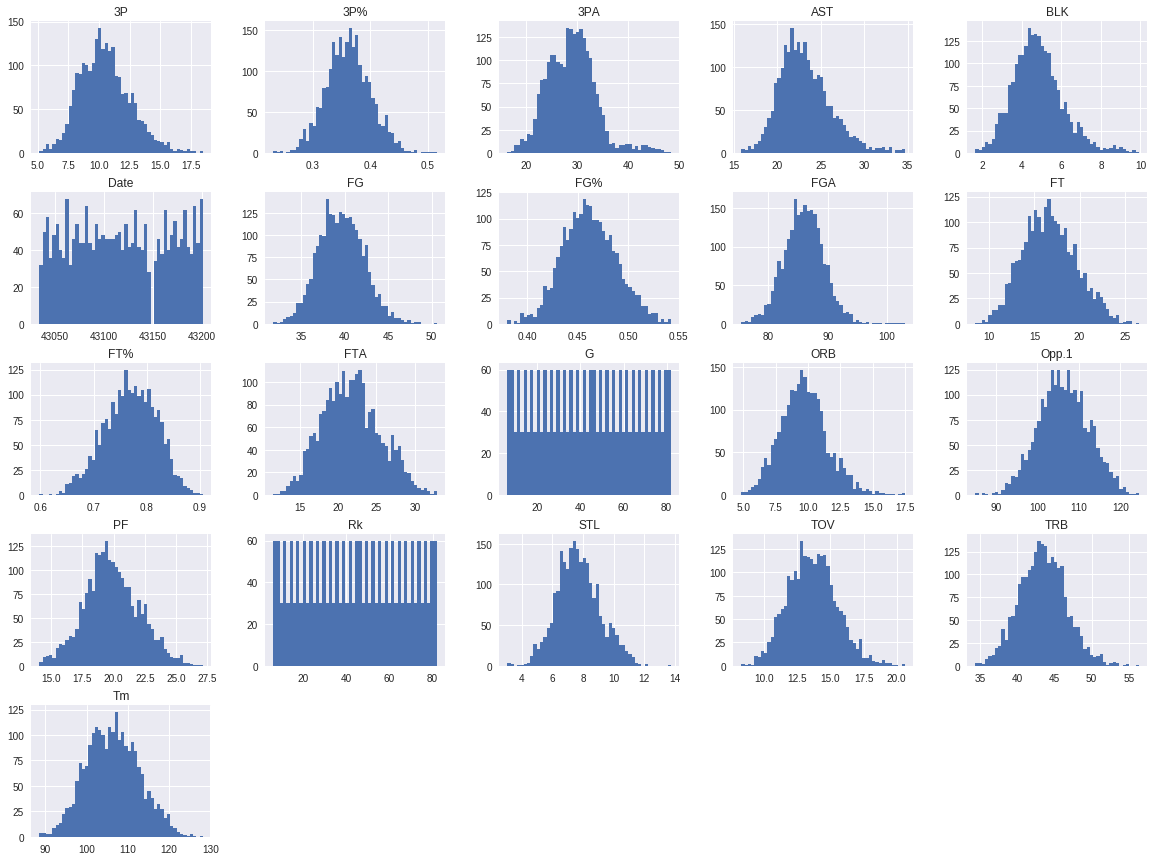

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
team.hist(bins=50, figsize=(20,15))
plt.show()

In [10]:
team['Unnamed: 4']=team['Unnamed: 4'].str.replace("@",'A')
team['Unnamed: 4']=team['Unnamed: 4'].fillna('H')
team['W/L']=team['W/L'].str.replace("W",'1')
team['W/L']=team['W/L'].str.replace("L",'0')
team.head()

,Rk,G,Date,TEAM,Unnamed: 4,Opp,W/L,Tm,Opp.1,FG,...,FT,FTA,FT%,ORB,TRB,AST,STL,BLK,TOV,PF
0,6,6,43038,TOR,A,POR,1,111.000000,100.80000,39.60000,...,21.600000,25.60000,0.841200,10.40000,43.200000,24.60000,9.600000,5.60000,14.400000,23.600000
1,6,6,43036,BOS,A,MIA,1,101.400000,96.00000,36.00000,...,18.600000,25.40000,0.730200,9.00000,46.000000,22.00000,9.000000,4.40000,13.600000,22.600000
2,6,6,43036,PHI,A,DAL,1,113.597198,106.74736,42.85182,...,14.283044,20.42887,0.701307,10.74154,48.938496,29.08946,8.978196,4.70043,17.192684,25.573782
3,6,6,43038,NYK,H,DEN,1,100.200000,101.40000,38.20000,...,16.200000,22.60000,0.705600,12.80000,45.800000,21.00000,7.600000,4.00000,15.200000,21.200000
4,6,6,43035,BRK,A,NYK,0,121.200000,119.40000,42.40000,...,24.400000,31.20000,0.778400,12.60000,45.800000,22.80000,10.200000,4.60000,16.600000,23.600000


### Home VS Away

In [11]:
team["Unnamed: 4"].value_counts()

A    1156
H    1154
Name: Unnamed: 4, dtype: int64

### W/L

In [12]:
team["W/L"].value_counts()

1    1156
0    1154
Name: W/L, dtype: int64

In [17]:
team[:1980]

,Rk,G,Date,TEAM,Unnamed: 4,Opp,W/L,Tm,Opp.1,FG,...,FT,FTA,FT%,ORB,TRB,AST,STL,BLK,TOV,PF
0,6,6,43038,TOR,A,POR,1,111.000000,100.800000,39.600000,...,21.600000,25.600000,0.841200,10.400000,43.200000,24.600000,9.600000,5.600000,14.400000,23.600000
1,6,6,43036,BOS,A,MIA,1,101.400000,96.000000,36.000000,...,18.600000,25.400000,0.730200,9.000000,46.000000,22.000000,9.000000,4.400000,13.600000,22.600000
2,6,6,43036,PHI,A,DAL,1,113.597198,106.747360,42.851820,...,14.283044,20.428870,0.701307,10.741540,48.938496,29.089460,8.978196,4.700430,17.192684,25.573782
3,6,6,43038,NYK,H,DEN,1,100.200000,101.400000,38.200000,...,16.200000,22.600000,0.705600,12.800000,45.800000,21.000000,7.600000,4.000000,15.200000,21.200000
4,6,6,43035,BRK,A,NYK,0,121.200000,119.400000,42.400000,...,24.400000,31.200000,0.778400,12.600000,45.800000,22.800000,10.200000,4.600000,16.600000,23.600000
5,6,6,43038,MIA,H,MIN,0,103.000000,106.000000,39.800000,...,13.000000,16.600000,0.777000,7.400000,40.400000,21.600000,7.200000,6.400000,14.800000,21.200000
6,6,6,43037,WAS,A,SAC,1,112.000000,110.400000,40.200000,...,23.200000,29.200000,0.785200,10.400000,42.600000,24.000000,10.200000,6.200000,13.400000,20.400000
7,6,6,43037,CHO,H,ORL,1,99.200000,99.600000,34.000000,...,21.000000,29.800000,0.711000,9.200000,49.200000,16.600000,4.600000,4.400000,15.000000,16.800000
8,6,6,43037,ORL,A,CHO,0,118.000000,107.200000,43.400000,...,18.800000,23.600000,0.770200,8.800000,45.800000,24.400000,8.200000,6.000000,15.200000,24.000000
9,6,6,43035,ATL,H,DEN,0,98.200000,106.200000,36.800000,...,16.400000,19.200000,0.839600,9.800000,43.400000,19.200000,9.400000,3.600000,14.400000,22.400000


In [0]:
from sklearn.model_selection import train_test_split
train_set = team[:1980]
test_set = team[1980:]
X_train = train_set.drop(['W/L','Rk','G','Date'],axis=1)
y_train = train_set['W/L'].copy()

In [0]:
team_02 = train_set.copy()

In [0]:
corr_matrix = team_02.corr()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f191e244550>,
      dtype=object)

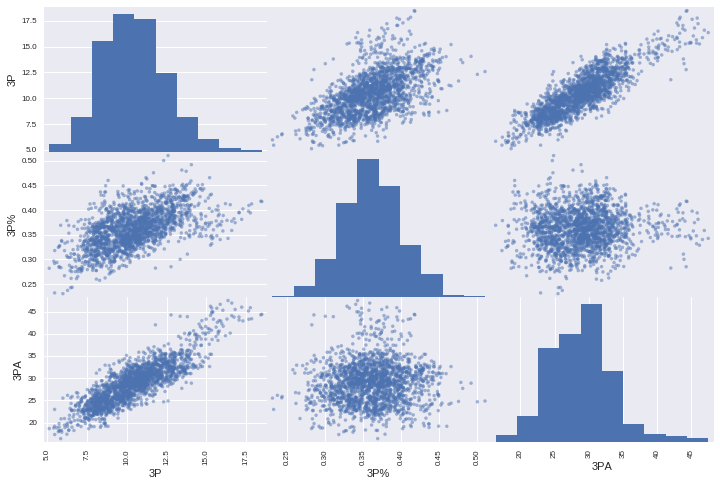

In [18]:
from pandas.plotting import scatter_matrix

attributes = ["3P", "3P%", "3PA"]
scatter_matrix(team_02[attributes], figsize=(12, 8))


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f191b3485d0>,
      dtype=object)

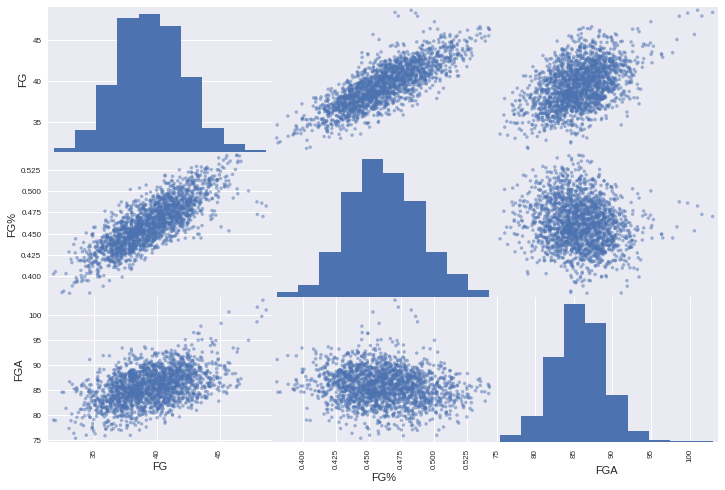

In [19]:
from pandas.plotting import scatter_matrix

attributes = ["FG", "FG%", "FGA"]
scatter_matrix(team_02[attributes], figsize=(12, 8))


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f191e4393d0>,
      dtype=object)

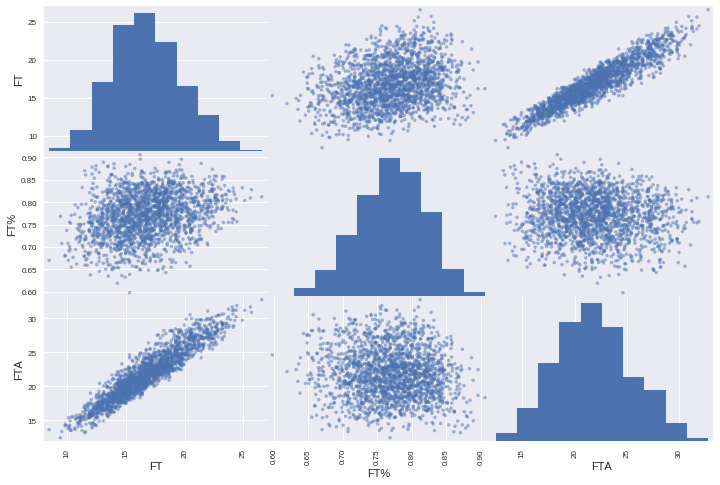

In [20]:
from pandas.plotting import scatter_matrix

attributes = ["FT", "FT%", "FTA"]
scatter_matrix(team_02[attributes], figsize=(12, 8))


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f191edae1d0>,
      dtype=object)

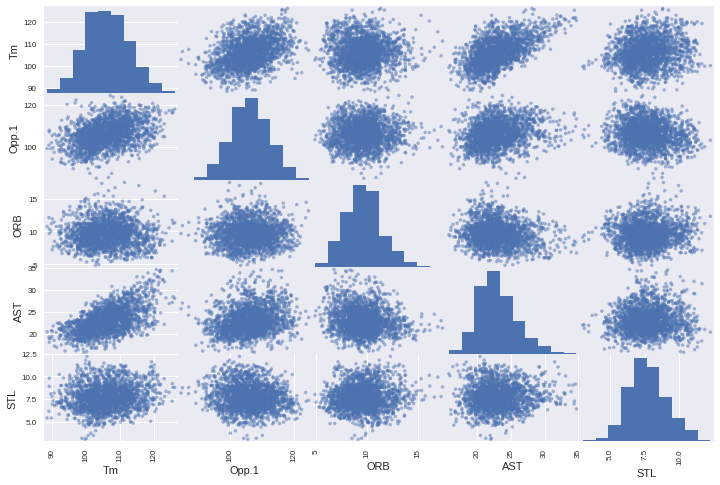

In [21]:
from pandas.plotting import scatter_matrix

attributes = ["Tm", "Opp.1", "ORB",'AST','STL']
scatter_matrix(team_02[attributes], figsize=(12, 8))


In [22]:

corr_matrix["Tm"].sort_values(ascending=False)


Tm       1.000000
FG       0.831788
FG%      0.716074
AST      0.585654
3P       0.447176
FT       0.401338
3P%      0.393052
Opp.1    0.375732
FTA      0.359911
FGA      0.310636
3PA      0.276808
BLK      0.257351
Date     0.179314
G        0.173903
Rk       0.173903
TRB      0.162582
FT%      0.142757
STL      0.133791
PF       0.021597
ORB     -0.002630
TOV     -0.071147
Name: Tm, dtype: float64

In [0]:
from sklearn.base import BaseEstimator, TransformerMixin

# A class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]

In [0]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Imputer

num_pipeline = Pipeline([
        ("select_numeric", DataFrameSelector(['3P','3P%','FG','FGA','FT','FT%','TOV','AST','Tm','Opp.1','BLK'])),
        ('std_scaler', StandardScaler()),
    ])

In [0]:
cat_pipeline = Pipeline([
        ("select_cat", DataFrameSelector(["Opp",'TEAM','Unnamed: 4'])),
        ("cat_encoder", OneHotEncoder(sparse=False)),
    ])

In [0]:
from sklearn.pipeline import FeatureUnion
preprocess_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

In [27]:
X_train_clean = preprocess_pipeline.fit_transform(train_set)
X_train_clean

array([[-0.1321443 , -1.66448638,  0.03036209, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.15876522,  0.15639148, -1.35359181, ...,  0.        ,
         1.        ,  0.        ],
       [ 1.52144065,  1.74516512,  1.28046458, ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [-0.92375297,  0.33918816, -0.02759778, ...,  0.        ,
         0.        ,  1.        ],
       [-0.39339069, -0.3305091 ,  0.09450892, ...,  0.        ,
         1.        ,  0.        ],
       [-0.19208385,  0.37174438, -0.95151402, ...,  0.        ,
         1.        ,  0.        ]])

In [0]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression

In [0]:
ada_clf_tree = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators= 200,algorithm='SAMME'
    ,learning_rate = .5
)
random_forest_clf = RandomForestClassifier(random_state=42)
extra_trees_clf = ExtraTreesClassifier(random_state=42)
svm_clf = LinearSVC(random_state=42)
mlp_clf = MLPClassifier(random_state=42)
log_clf = LogisticRegression(random_state=0, solver='lbfgs',
                         multi_class='multinomial').fit(X_train_clean, y_train)

In [30]:
voting_clf = VotingClassifier(
    estimators=[('ada',ada_clf_tree),
                ('mlp',mlp_clf),('log',log_clf)],
    voting = 'soft')
voting_clf.fit(X_train_clean,y_train)
log_clf = LogisticRegression(random_state=0, solver='lbfgs',
                         multi_class='multinomial').fit(X_train_clean, y_train)
estimators = [random_forest_clf, extra_trees_clf, svm_clf, mlp_clf,ada_clf_tree,voting_clf,log_clf]
for estimator in estimators:
    print("Training the", estimator)
    estimator.fit(X_train_clean, y_train)

/usr/local/lib/python2.7/dist-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


('Training the', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False))
('Training the', ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False))
('Training the', LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     mult

In [31]:
from sklearn.model_selection import cross_val_score
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())
for estimator in estimators:
  A =(cross_val_score(estimator, X_train_clean, y_train,scoring="accuracy", cv=5))
  display_scores(A)

('Scores:', array([0.55163728, 0.61111111, 0.52525253, 0.61363636, 0.63291139]))
('Mean:', 0.5869097344004082)
('Standard deviation:', 0.041138617847352836)
('Scores:', array([0.62468514, 0.62878788, 0.54545455, 0.65151515, 0.65316456]))
('Mean:', 0.6207214542517288)
('Standard deviation:', 0.039361636811577345)
('Scores:', array([0.65491184, 0.68181818, 0.56818182, 0.68686869, 0.72911392]))
('Mean:', 0.6641788899420503)
('Standard deviation:', 0.05356089278703771)
('Scores:', array([0.5768262 , 0.61868687, 0.58080808, 0.65656566, 0.66835443]))
('Mean:', 0.6202482465827809)
('Standard deviation:', 0.0376207341776575)
('Scores:', array([0.61712846, 0.62626263, 0.56565657, 0.64141414, 0.67088608]))
('Mean:', 0.6242695745517542)
('Standard deviation:', 0.03451807326522565)


/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

('Scores:', array([0.58186398, 0.63383838, 0.57828283, 0.65656566, 0.67848101]))
('Mean:', 0.6258063722387927)
('Standard deviation:', 0.03993666386927765)
('Scores:', array([0.65743073, 0.67424242, 0.57575758, 0.68181818, 0.7443038 ]))
('Mean:', 0.666710541953025)
('Standard deviation:', 0.05415577586063268)


In [32]:
#svm
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon, reciprocal


param_distribs = {
        'kernel': ['linear', 'rbf'],
        'C': reciprocal(1, 50),
        'gamma': expon(scale=1.0),
        'probability':[True],
    }

svm_reg = SVC()
rnd_search = RandomizedSearchCV(SVC(), param_distributions=param_distribs,
                                n_iter=15, cv=3, scoring='accuracy',
                                verbose=2, n_jobs=4, random_state=42)
rnd_search.fit(X_train_clean, y_train)

Fitting 3 folds for each of 15 candidates, totalling 45 fits
[CV] kernel=linear, C=4.32845022129388, gamma=3.010121430917521, probability=True 
[CV] kernel=linear, C=4.32845022129388, gamma=3.010121430917521, probability=True 
[CV] kernel=rbf, C=21.118915966823938, gamma=0.9084469696321253, probability=True 
[CV] kernel=linear, C=4.32845022129388, gamma=3.010121430917521, probability=True 
[CV]  kernel=rbf, C=21.118915966823938, gamma=0.9084469696321253, probability=True, total=   3.6s
[CV] kernel=rbf, C=21.118915966823938, gamma=0.9084469696321253, probability=True 
[CV]  kernel=linear, C=4.32845022129388, gamma=3.010121430917521, probability=True, total=   5.9s
[CV] kernel=rbf, C=21.118915966823938, gamma=0.9084469696321253, probability=True 
[CV]  kernel=linear, C=4.32845022129388, gamma=3.010121430917521, probability=True, total=   6.4s
[CV] kernel=rbf, C=1.8408992080552518, gamma=0.059838768608680676, probability=True 
[CV]  kernel=linear, C=4.32845022129388, gamma=3.0101214309175

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  1.1min


[CV]  kernel=linear, C=10.769622478263127, gamma=0.18696125197741642, probability=True, total=  12.7s
[CV] kernel=linear, C=10.769622478263127, gamma=0.18696125197741642, probability=True 
[CV]  kernel=linear, C=46.8252152359852, gamma=0.628789100540856, probability=True, total=  48.0s
[CV] kernel=linear, C=10.769622478263127, gamma=0.18696125197741642, probability=True 
[CV]  kernel=linear, C=10.769622478263127, gamma=0.18696125197741642, probability=True, total=  15.7s
[CV] kernel=rbf, C=1.053262861679251, gamma=2.850796878935603, probability=True 
[CV]  kernel=rbf, C=1.053262861679251, gamma=2.850796878935603, probability=True, total=   3.8s
[CV] kernel=rbf, C=1.053262861679251, gamma=2.850796878935603, probability=True 
[CV]  kernel=linear, C=10.769622478263127, gamma=0.18696125197741642, probability=True, total=  15.1s
[CV] kernel=rbf, C=1.053262861679251, gamma=2.850796878935603, probability=True 
[CV]  kernel=rbf, C=1.053262861679251, gamma=2.850796878935603, probability=True, t

[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  2.2min finished


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
          fit_params=None, iid=True, n_iter=15, n_jobs=4,
          param_distributions={'kernel': ['linear', 'rbf'], 'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f191ee40ad0>, 'probability': [True], 'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f191ed09690>},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring='accuracy', verbose=2)

In [33]:
model_svc = rnd_search.best_estimator_
model_svc

SVC(C=21.576967455896824, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.2227358621286903,
  kernel='linear', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [0]:
over_fit=SVC(C=61, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.0007790692366582295,
  kernel='rbf', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [35]:
A =(cross_val_score(model_svc, X_train_clean, y_train,scoring="accuracy", cv=5))
display_scores(A)

('Scores:', array([0.65239295, 0.67171717, 0.56313131, 0.68181818, 0.73924051]))
('Mean:', 0.661660024019811)
('Standard deviation:', 0.057131452571942916)


In [257]:

A =(cross_val_score(model_svc, X_train_clean, y_train,scoring="accuracy", cv=5))
display_scores(A)

('Scores:', array([0.60957179, 0.66666667, 0.57070707, 0.64393939, 0.70379747]))
('Mean:', 0.6389364776161319)
('Standard deviation:', 0.04586606068810053)


In [36]:
from sklearn.metrics import confusion_matrix
A =model_svc.predict(X_train_clean)
confusion_matrix(y_train, A)

array([[693, 296],
       [306, 685]])

In [37]:
def ac(a,b):
  return(a/(a+b))
def rec(a,b):
  return(a/(a+b))
def f1(a,b,c):
  return(a/(a+(b+c)/2))

ac(685,306)

0.6912209889001009

In [38]:
#recall
rec(685,296)

0.6982670744138634

In [39]:
#f1
f1(685,296,306)


0.6947261663286004

In [0]:
prob=model_svc.predict_proba(X_train_clean)
prob = prob[:,1]

In [0]:
hold = []
y_rand =prob>.65
for i in y_rand:
  hold.append(str(int(i==True)))

In [42]:
confusion_matrix(y_train, hold)

array([[877, 112],
       [575, 416]])

In [43]:
ac(416,575)

0.41977800201816345

In [44]:
rec(416,112)

0.7878787878787878

In [45]:
f1(416,112,575)

0.5477287689269256

In [0]:
train_pred =model_svc.predict(X_train_clean)
train_prob = model_svc.predict_proba(X_train_clean)


In [47]:
y_train =np.array( y_train,dtype='int')

train_pred = np.array(train_pred,dtype='int')

from sklearn.metrics import roc_auc_score

roc_auc_score(y_train, train_pred)

0.6959643872710818

In [0]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train, train_pred)

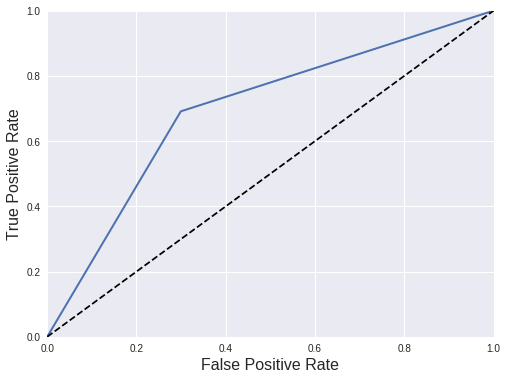

In [49]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
plt.show()

In [0]:
X_test = test_set.drop('W/L',axis=1)
y_test = test_set['W/L'].copy()

In [51]:
X_test_clean = preprocess_pipeline.transform(X_test)
X_test_clean

array([[ 9.96151036e-01,  7.98245501e-01,  6.58289311e-01, ...,
         0.00000000e+00,  1.00000000e+00,  0.00000000e+00],
       [ 2.34460179e-01,  1.62589091e-01, -8.11505081e-01, ...,
         0.00000000e+00,  1.00000000e+00,  0.00000000e+00],
       [ 5.27788930e-01, -3.32383687e-01,  1.83316560e+00, ...,
         0.00000000e+00,  0.00000000e+00,  1.00000000e+00],
       ...,
       [-1.37092687e+00, -5.98284838e-01,  2.85348033e-01, ...,
         0.00000000e+00,  1.00000000e+00,  0.00000000e+00],
       [ 1.13580598e+00, -5.10943144e-01, -4.56259431e-01, ...,
         0.00000000e+00,  0.00000000e+00,  1.00000000e+00],
       [-5.08412162e-01, -5.92887641e-02,  5.27790640e-04, ...,
         0.00000000e+00,  1.00000000e+00,  0.00000000e+00]])

In [0]:
test_pred =model_svc.predict(X_test_clean)
test_prob = model_svc.predict_proba(X_test_clean)


In [53]:
confusion_matrix(test_pred, y_test)

array([[113,  56],
       [ 52, 109]])

In [55]:
ac(109,52)

0.6770186335403726

In [56]:
rec(109,56)

0.6606060606060606

In [57]:
f1(109,56,52)

0.6687116564417178

In [58]:
y_test =np.array( y_test,dtype='int')
y_test
test_pred = np.array(test_pred,dtype='int')

from sklearn.metrics import roc_auc_score

roc_auc_score(y_test, test_pred)

0.6727272727272727

In [0]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, test_pred)

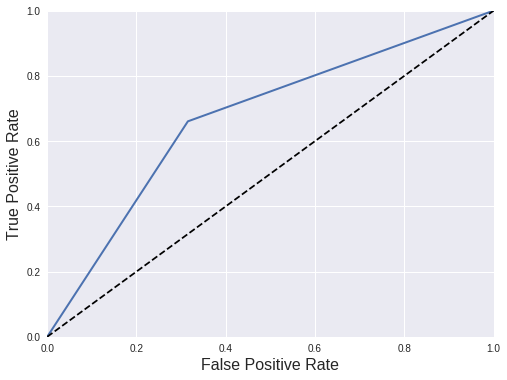

In [60]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
plt.show()

In [0]:
hold_test = []
y_rand =test_prob[:,1]>.65
for i in y_rand:
  hold_test.append(str(int(i==True)))

In [0]:
hold_test = np.array(hold_test,dtype='int')


In [63]:
confusion_matrix(y_test, hold_test)

array([[143,  22],
       [111,  54]])

In [64]:
ac(54,111)

0.32727272727272727

In [65]:
rec(54,22)

0.7105263157894737

In [67]:
f1(54,22,111)

0.44813278008298757